# Reconstructing MNIST with HM sampler in the latent space with vMF distribution

*Final Project: Computational Statistics MVA 2022-2023*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/MVA/comp_stat/project/hyperspherical_vae_hm/

/content/gdrive/MyDrive/MVA/comp_stat/project/hyperspherical_vae_hm


In [ ]:
ls

basic_animation.gif  legend.png                  test_perf.npy
basic_animation.mp4  mnist_grid.pdf              Train_HM.ipynb
data/                mnist.py                    training_perf.csv
hspherical_VAE.pkl   reconstructing_MNIST.ipynb  training_performance.png
hyperspherical_vae/  sampling_latent_space.png


## Code for model (mostly similar to what is in file MNIST.py)

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from collections import defaultdict

from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform


train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True,
    transform=transforms.ToTensor()), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, download=True,
    transform=transforms.ToTensor()), batch_size=64)


class ModelVAE(torch.nn.Module):
    
    def __init__(self, h_dim, z_dim, activation=F.relu, distribution='normal'):
        """
        ModelVAE initializer
        :param h_dim: dimension of the hidden layers
        :param z_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(ModelVAE, self).__init__()
        
        self.z_dim, self.activation, self.distribution = z_dim, activation, distribution
        
        # 2 hidden layers encoder
        self.fc_e0 = nn.Linear(784, h_dim * 2)
        self.fc_e1 = nn.Linear(h_dim * 2, h_dim)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var =  nn.Linear(h_dim, z_dim)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var = nn.Linear(h_dim, 1)
        else:
            raise NotImplemented
            
        # 2 hidden layers decoder
        self.fc_d0 = nn.Linear(z_dim, h_dim)
        self.fc_d1 = nn.Linear(h_dim, h_dim * 2)
        self.fc_logits = nn.Linear(h_dim * 2, 784)

    def encode(self, x):
        # 2 hidden layers encoder
        x = self.activation(self.fc_e0(x))
        x = self.activation(self.fc_e1(x))
        
        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(x)
            z_var = F.softplus(self.fc_var(x))
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(x)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(x)) + 1
        else:
            raise NotImplemented
        
        return z_mean, z_var
        
    def decode(self, z):
        
        x = self.activation(self.fc_d0(z))
        x = self.activation(self.fc_d1(x))
        x = self.fc_logits(x)
        
        return x
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(self.z_dim - 1)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        x_ = self.decode(z)
        
        return (z_mean, z_var), (q_z, p_z), z, x_
    
    
def log_likelihood(model, x, n=10):
    """
    :param model: model object
    :param optimizer: optimizer object
    :param n: number of MC samples
    :return: MC estimate of log-likelihood
    """

    z_mean, z_var = model.encode(x.reshape(-1, 784))
    q_z, p_z = model.reparameterize(z_mean, z_var)
    z = q_z.rsample(torch.Size([n]))
    x_mb_ = model.decode(z)

    log_p_z = p_z.log_prob(z)

    if model.distribution == 'normal':
        log_p_z = log_p_z.sum(-1)

    log_p_x_z = -nn.BCEWithLogitsLoss(reduction='none')(x_mb_, x.reshape(-1, 784).repeat((n, 1, 1))).sum(-1)

    log_q_z_x = q_z.log_prob(z)

    if model.distribution == 'normal':
        log_q_z_x = log_q_z_x.sum(-1)

    return ((log_p_x_z + log_p_z - log_q_z_x).t().logsumexp(-1) - np.log(n)).mean()


def train(model, optimizer):
    for i, (x_mb, y_mb) in enumerate(train_loader):

            optimizer.zero_grad()
            
            # dynamic binarization
            x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape)).float()

            _, (q_z, p_z), _, x_mb_ = model(x_mb.reshape(-1, 784))

            loss_recon = nn.BCEWithLogitsLoss(reduction='none')(x_mb_, x_mb.reshape(-1, 784)).sum(-1).mean()

            if model.distribution == 'normal':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
            elif model.distribution == 'vmf':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
            else:
                raise NotImplemented

            loss = loss_recon + loss_KL
            loss.backward()
            optimizer.step()
    
    return(loss_recon.item(), loss_KL.item(), -loss.item())
            
            
def test(model, optimizer):
    print_ = defaultdict(list)
    latent_z =  []
    latent_y = []
    for x_mb, y_mb in test_loader:
        
        # dynamic binarization
        x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape)).float()
        
        (z_mean, z_var), (q_z, p_z), z, x_mb_ = model(x_mb.reshape(-1, 784))
        
        latent_z.append(z.detach().numpy())
        latent_y.append(y_mb.detach().numpy())
        print_['recon loss'].append(float(nn.BCEWithLogitsLoss(reduction='none')(x_mb_,
            x_mb.reshape(-1, 784)).sum(-1).mean().data))
        
        if model.distribution == 'normal':
            print_['KL'].append(float(torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean().data))
        elif model.distribution == 'vmf':
            print_['KL'].append(float(torch.distributions.kl.kl_divergence(q_z, p_z).mean().data))
        else:
            raise NotImplemented
        
        print_['ELBO'].append(- print_['recon loss'][-1] - print_['KL'][-1])
        print_['LL'].append(float(log_likelihood(model, x_mb).data))
    
    print({k: np.mean(v) for k, v in print_.items()})
    latent_z = np.vstack(latent_z)
    latent_y = np.hstack(latent_y)
    return(print_), latent_z, latent_y

In [ ]:
# hidden dimension and dimension of latent space
H_DIM = 128
Z_DIM = 2

# normal VAE
modelN = ModelVAE(h_dim=H_DIM, z_dim=Z_DIM, distribution='normal')
optimizerN = optim.Adam(modelN.parameters(), lr=1e-3)

# print('##### Normal VAE #####')

# # training for 1 epoch
# train(modelN, optimizerN)

# # test
# test(modelN, optimizerN)

# print()

# hyper-spherical  VAE
modelS = ModelVAE(h_dim=H_DIM, z_dim=Z_DIM + 1, distribution='vmf')
optimizerS = optim.Adam(modelS.parameters(), lr=1e-3)

print('##### Hyper-spherical VAE #####')

# training for 1 epoch
N_EPOCHS = 100
res = np.zeros((N_EPOCHS, 3))
for ep in range(N_EPOCHS):
    recon, kl, elbo = train(modelS, optimizerS)
    res[ep] = [recon, kl, elbo]
    if ep % 5 == 0:
        print(f"Epoch {ep} : loss_recon={recon}, KL={kl}, ELBO={elbo}")

df_res = pd.DataFrame(res, columns=['recon loss', 'KL loss', 'ELBO'])
df_res.to_csv("training_perf_2.csv")

# test
test_perf, _ = test(modelS, optimizerS)
np.save('test_perf_2.npy', test_perf)

##### Hyper-spherical VAE #####


/usr/local/lib/python3.8/dist-packages/torch/distributions/distribution.py:45: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0 : loss_recon=162.01463317871094, KL=4.558313846588135, ELBO=-166.5729522705078
Epoch 5 : loss_recon=139.78900146484375, KL=5.9394097328186035, ELBO=-145.72840881347656
Epoch 10 : loss_recon=129.27313232421875, KL=6.243595123291016, ELBO=-135.5167236328125
Epoch 15 : loss_recon=136.8406524658203, KL=6.5784173011779785, ELBO=-143.4190673828125
Epoch 20 : loss_recon=126.33768463134766, KL=6.628073215484619, ELBO=-132.96575927734375
Epoch 25 : loss_recon=145.8448028564453, KL=6.606091022491455, ELBO=-152.45089721679688
Epoch 30 : loss_recon=139.65081787109375, KL=6.708811283111572, ELBO=-146.35963439941406
Epoch 35 : loss_recon=132.89830017089844, KL=6.908227443695068, ELBO=-139.80653381347656
Epoch 40 : loss_recon=123.06419372558594, KL=6.934393405914307, ELBO=-129.9985809326172
Epoch 45 : loss_recon=117.02330017089844, KL=7.04094934463501, ELBO=-124.06424713134766
Epoch 50 : loss_recon=118.06922149658203, KL=7.141648769378662, ELBO=-125.21086883544922
Epoch 55 : loss_recon=124.53

In [ ]:
torch.save(modelS, './hspherical_VAE_2.pkl')

In [ ]:
test_perf, latent_z, latent_y = test(modelS, optimizerS)

/usr/local/lib/python3.8/dist-packages/torch/distributions/distribution.py:45: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


{'recon loss': 128.54778527909784, 'KL': 7.126753725064028, 'ELBO': -135.67453900416186, 'LL': -133.67840498420082}


## Visualizing latent space

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

def init():
  ax.scatter(latent_z[:,0],latent_z[:,1],latent_z[:,2],s=5, c=latent_y, cmap='Paired')
  ax.set_axis_off()
  return fig,

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
import matplotlib

In [ ]:
colors = [plt.cm.Paired(i) for i in range(10)]

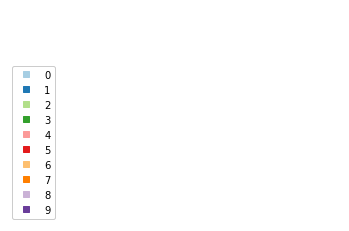

In [ ]:
f = lambda m,c: plt.plot([],[], marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(10)]
labels = np.unique(latent_y).astype(str)
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=True)

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
    
plt.gca().set_axis_off()
export_legend(legend)
plt.show()

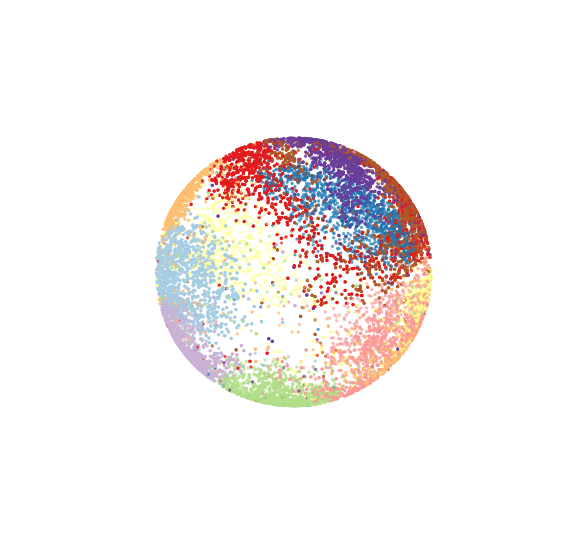

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=False)
# Save
anim.save('basic_animation.gif', writer='pillow', fps=30)
plt.show()

## Sampling latent space and reconstructing digits

In [ ]:
import numpy as np
import plotly.graph_objs as go
from numpy import pi, sin, cos

In [ ]:
theta = np.linspace(0, 2*pi, 120)
phi = np.linspace(0, pi, 60)
u , v = np.meshgrid(theta, phi)
xs = np.cos(u)*np.sin(v)
ys = np.sin(u)*np.sin(v)
zs = np.cos(v)

x = []
y = []
z = []
for t in [theta[10*k] for k in range(0,12,2)]:  # meridians:
    x.extend(list(cos(t)*sin(phi))+[None])# None is inserted to mark the end of a meridian line
    y.extend(list(sin(t)*sin(phi))+[None]) 
    z.extend(list(cos(phi))+[None])
    
for s in [phi[6*k] for k in range(0,10,2)]:  # parallels
    x.extend(list(cos(theta)*sin(s))+[None]) # None is inserted to mark the end of a parallel line 
    y.extend(list(sin(theta)*sin(s))+[None]) 
    z.extend([cos(s)]*120+[None])

fig=go.Figure()
fig.add_surface(x=xs, y=ys, z=zs, 
                colorscale=[[0, '#ffffff' ], [1, '#ffffff']], 
                showscale=False, opacity=0.5)  # or opacity=1
fig.add_scatter3d(x=x, y=y, z=z, mode='lines', line_width=3, line_color='rgb(10,10,10)')
fig.update_layout(width=700, height=700)

In [ ]:
x_filt = list(filter(lambda item: item is not None, x))
y_filt = list(filter(lambda item: item is not None, y))
z_filt = list(filter(lambda item: item is not None, z))

In [ ]:
z_grid = np.vstack([x_filt, y_filt, z_filt]).T

In [ ]:
t_grid = torch.from_numpy(z_grid)

In [ ]:
t_grid = t_grid.type(torch.float32)

In [ ]:
reconstructed = modelS.decode(t_grid)

In [ ]:
reconstructed = reconstructed.detach().numpy()

In [ ]:
reconstructed_bin = reconstructed > 0

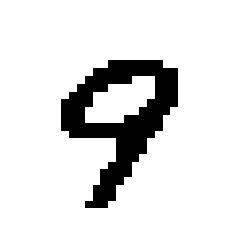

In [ ]:
plt.imshow(reconstructed_bin[0].reshape((28, 28)), cmap='gray_r')
plt.axis('off')
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

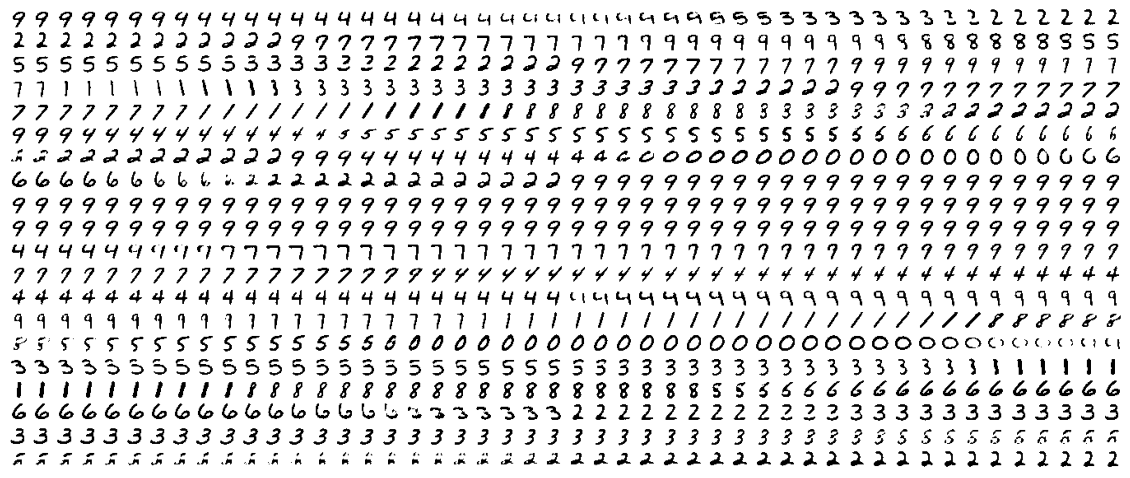

In [ ]:
fig = plt.figure(figsize=(20, 40))
grid = ImageGrid(fig, 111,
                  nrows_ncols=(20, 48),
                  axes_pad=0.01)

for ax, im in zip(grid, reconstructed_bin):
  ax.imshow(im.reshay pe((28, 28)), cmap='gray_r')
  ax.set_axis_off()
plt.savefig('./mnist_grid.pdf', dpi=300)
plt.show()

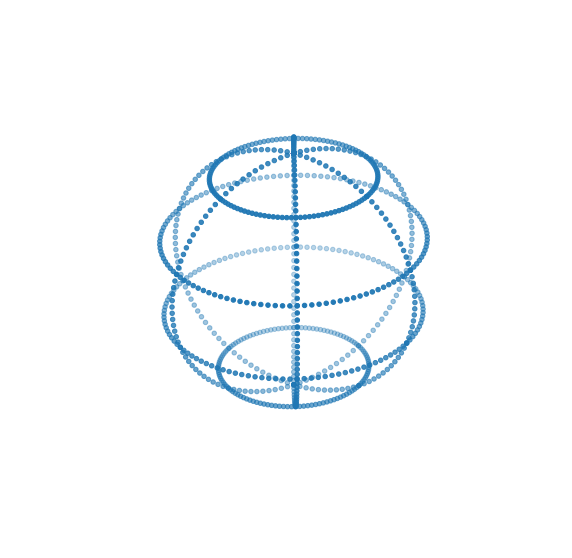

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x_filt, y_filt, z_filt)
ax.set_axis_off()
plt.savefig('./sampling_latent_space.png', dpi=300)
plt.show()